In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np


In [15]:
# Load sequences
music_sequences = np.load('good_music_midi.npy')

class MusicDataset(Dataset):
    def __init__(self, music_sequences, sequence_length):
        self.music_sequences = music_sequences
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.music_sequences) - self.sequence_length
    
    def __getitem__(self, idx):
        sequence = self.music_sequences[idx, 0:self.sequence_length]
        target = self.music_sequences[idx, 1:self.sequence_length+1]
        return torch.tensor(sequence, dtype=torch.long), torch.tensor(target, dtype=torch.long)

class MusicLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(MusicLSTM, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

# def train(model, data_loader, epochs, learning_rate):
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
#     for epoch in range(epochs):
#         for i, (sequence, target) in enumerate(data_loader):
#             optimizer.zero_grad()
#             outputs = model(sequence)
#             loss = criterion(outputs.view(-1, outputs.shape[2]), target.view(-1))
#             loss.backward()
#             optimizer.step()
            
#             if (i+1) % 100 == 0:
#                 print(f'Epoch[{epoch+1}/{epochs}], Step[{i+1}/{len(data_loader)}], Loss: {loss.item():.4f}')

def train(model, data_loader, epochs, learning_rate, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses = []
    for epoch in range(epochs):
        for i, (sequence, target) in enumerate(data_loader):
            sequence, target = sequence.to(device), target.to(device)  # Move tensors to the device
            
            optimizer.zero_grad()
            outputs = model(sequence)
            loss = criterion(outputs.view(-1, outputs.shape[2]), target.view(-1))
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            
            if (i+1) % 50 == 0:
                print(f'Epoch[{epoch+1}/{epochs}], Step[{i+1}/{len(data_loader)}], Loss: {loss.item():.4f}')
                
    return losses





In [16]:
# Hyperparameters
input_size = 382
hidden_size = 512
output_size = input_size
num_layers = 2
sequence_length = 100
batch_size = 64
epochs = 30
learning_rate = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Dataset and DataLoader
data_loader = MusicDataset(music_sequences, sequence_length)
data_loader = DataLoader(data_loader, batch_size=batch_size, shuffle=True)

# Model
model = MusicLSTM(input_size, hidden_size, output_size, num_layers)
model.to(device)

# Train the model
losses = train(model, data_loader, epochs, learning_rate, device)

cuda
Epoch[1/30], Step[50/88], Loss: 3.7625
Epoch[2/30], Step[50/88], Loss: 3.3546
Epoch[3/30], Step[50/88], Loss: 3.0883
Epoch[4/30], Step[50/88], Loss: 2.7514
Epoch[5/30], Step[50/88], Loss: 2.6003
Epoch[6/30], Step[50/88], Loss: 2.4027
Epoch[7/30], Step[50/88], Loss: 2.2894
Epoch[8/30], Step[50/88], Loss: 2.1476
Epoch[9/30], Step[50/88], Loss: 2.0192
Epoch[10/30], Step[50/88], Loss: 1.8870
Epoch[11/30], Step[50/88], Loss: 1.7721
Epoch[12/30], Step[50/88], Loss: 1.6113
Epoch[13/30], Step[50/88], Loss: 1.4836
Epoch[14/30], Step[50/88], Loss: 1.3763
Epoch[15/30], Step[50/88], Loss: 1.2663
Epoch[16/30], Step[50/88], Loss: 1.1645
Epoch[17/30], Step[50/88], Loss: 1.0901
Epoch[18/30], Step[50/88], Loss: 0.9547
Epoch[19/30], Step[50/88], Loss: 0.8394
Epoch[20/30], Step[50/88], Loss: 0.7713
Epoch[21/30], Step[50/88], Loss: 0.6852
Epoch[22/30], Step[50/88], Loss: 0.5827
Epoch[23/30], Step[50/88], Loss: 0.5450
Epoch[24/30], Step[50/88], Loss: 0.4681
Epoch[25/30], Step[50/88], Loss: 0.4052
Epoc

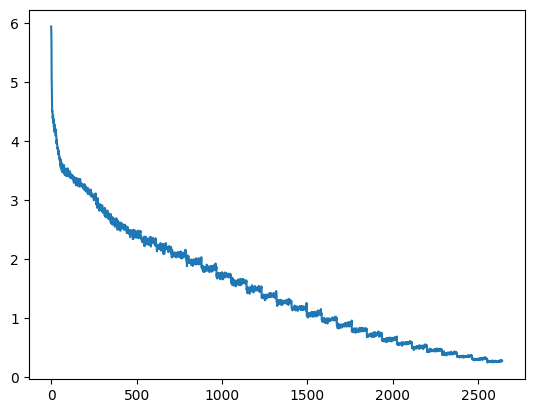

In [14]:
import matplotlib.pyplot as plt 

plt.plot(losses)

In [17]:
from model_base import ComposerBase 

In [34]:
class Composer(ComposerBase):
    def __init__(self, model, vocab_size, device):
        super().__init__()
        self.model = model
        self.vocab_size = vocab_size
        self.device = device

    def compose(self, n, temperature=1.0):
        self.model.eval()  # Set the model to evaluation mode
        
        generated_sequence = [np.random.randint(self.vocab_size)]
        with torch.no_grad():
            for _ in range(n):
                input_tensor = torch.tensor([generated_sequence[-1]], dtype=torch.long).to(self.device)
                input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension
                
                output = self.model(input_tensor)
                output = output.squeeze().div(temperature).exp()
                next_note = torch.multinomial(output, 1).item()
                
                generated_sequence.append(next_note)

        return np.array(generated_sequence)
    
    def train(self, x):
        pass

In [35]:
composer = Composer(model, input_size, device)

In [36]:
composer.compose(100)

array([376,  86, 373,  63, 260, 256, 191, 256, 157, 257, 194, 259, 256,
       202, 214, 256, 363,  76, 257, 368,  65,  87, 256, 366,  84, 257,
       256,  95, 214, 257, 256, 167, 259, 256, 192, 257, 178, 256, 202,
       267, 357,  69, 370,  69, 256, 176, 263, 195, 261, 256, 195, 207,
       363,  68, 257, 192, 257, 369,  45, 256, 366,  45, 256, 178, 256,
       369,  86, 259, 256, 369,  65, 275, 256, 199, 256, 371,  34, 257,
       368,  76, 257, 188, 185, 259, 256, 369,  69, 261, 256, 204, 219,
       256, 369,  39, 335, 256, 376,  69, 370,  69, 199])

In [37]:
from midi2seq import seq2piano 

In [39]:
midi_obj = seq2piano(composer.compose(200))
midi_obj.write('test.mid')

DEBUG:up without down for pitch 50 at time 0
DEBUG:up without down for pitch 55 at time 0
DEBUG:consecutive downs for pitch 75 at time 0 and 0
DEBUG:up without down for pitch 57 at time 0
DEBUG:up without down for pitch 48 at time 0
DEBUG:up without down for pitch 48 at time 1
DEBUG:up without down for pitch 71 at time 1
DEBUG:up without down for pitch 49 at time 1
DEBUG:up without down for pitch 100 at time 1
DEBUG:up without down for pitch 100 at time 1
DEBUG:up without down for pitch 67 at time 1
DEBUG:consecutive downs for pitch 86 at time 1 and 1
DEBUG:up without down for pitch 74 at time 1
DEBUG:note with non-positive duration for pitch 91 at time 1
DEBUG:up without down for pitch 47 at time 1
DEBUG:up without down for pitch 91 at time 1
DEBUG:consecutive downs for pitch 48 at time 2 and 2
DEBUG:consecutive downs for pitch 64 at time 0 and 2
DEBUG:up without down for pitch 63 at time 2
DEBUG:up without down for pitch 72 at time 2
DEBUG:up without down for pitch 77 at time 2
DEBUG